In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
import category_encoders as ce
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout , Input , BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay, classification_report
from tensorflow.keras.optimizers import RMSprop, Adam

In [2]:
ruta = "C:/Users/serch/Downloads/DataScience/Tema 6/Dogs Dataset/"

In [3]:
df_raw = pd.read_csv(ruta + '/dogs.csv')
df_raw.head()

filepaths  labels data set
0  train/Afghan/001.jpg  Afghan    train
1  train/Afghan/002.jpg  Afghan    train
2  train/Afghan/003.jpg  Afghan    train
3  train/Afghan/004.jpg  Afghan    train
4  train/Afghan/005.jpg  Afghan    train

In [4]:
df_raw["data set"].value_counts()

data set
train    7946
test      700
valid     700
Name: count, dtype: int64

Trabajaremos con las 3 razas con más imágenes

In [5]:
df = df_raw[(df_raw["labels"]=="Lhasa")
            | (df_raw["labels"]=="Shih-Tzu")
            | (df_raw["labels"]=="Labrador")]
df["labels"].value_counts()

labels
Shih-Tzu    218
Lhasa       207
Labrador    181
Name: count, dtype: int64

In [6]:
# Revolvamos las filas del nuevo dataframe
np.random.seed(123)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(drop=True,inplace=True)

df.head()

filepaths    labels data set
0     train/Lhasa/057.jpg     Lhasa    train
1  train/Labrador/012.jpg  Labrador    train
2     train/Lhasa/150.jpg     Lhasa    train
3  train/Labrador/103.jpg  Labrador    train
4  train/Shih-Tzu/160.jpg  Shih-Tzu    train

In [7]:
# Entrenamiento
X_train_paths = df[df["data set"]=="train"]["filepaths"].values
X_train = np.array([plt.imread(ruta + X_train_paths[i]) for i in range(len(X_train_paths))])
y_train = df[df["data set"]=="train"]["labels"].values

# Validación
X_val_paths = df[df["data set"]=="valid"]["filepaths"].values
X_val = np.array([plt.imread(ruta + X_val_paths[i]) for i in range(len(X_val_paths))])
y_val = df[df["data set"]=="valid"]["labels"].values

# Prueba
X_test_paths = df[df["data set"]=="test"]["filepaths"].values
X_test = np.array([plt.imread(ruta + X_test_paths[i]) for i in range(len(X_test_paths))])
y_test = df[df["data set"]=="test"]["labels"].values

In [8]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((546, 224, 224, 3),
 (546,),
 (30, 224, 224, 3),
 (30,),
 (30, 224, 224, 3),
 (30,))

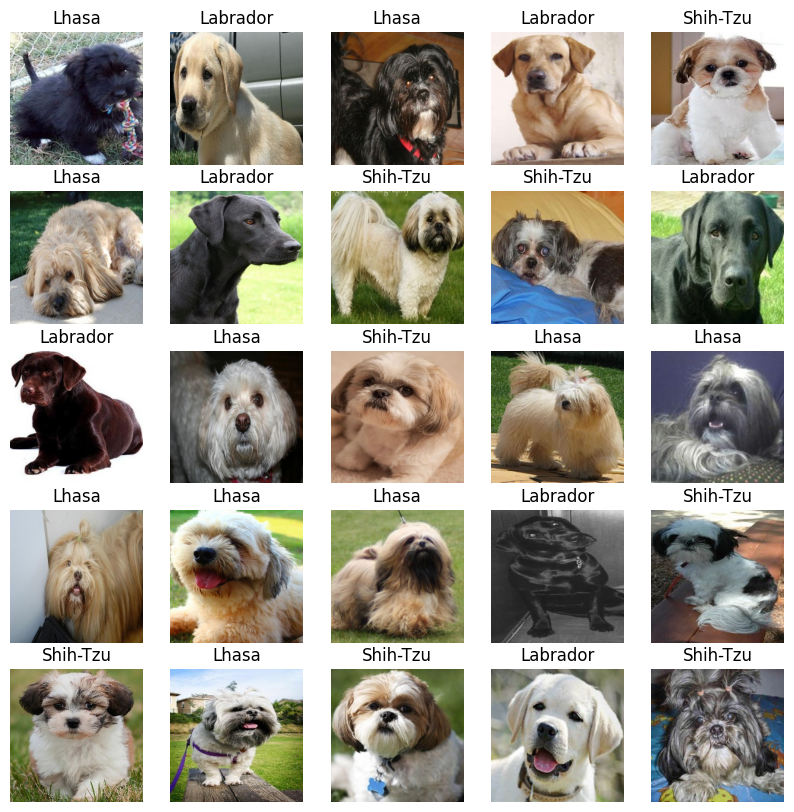

In [9]:
plt.figure(figsize = (10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i])
    plt.title(f"{y_train[i]}")
    plt.axis('off')
plt.show()

(546, 224, 224, 3)

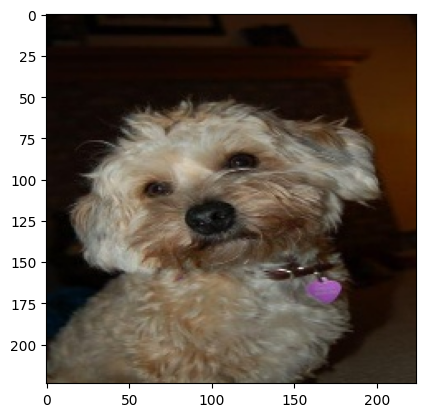

In [10]:
plt.imshow(X_train[200])
X_train.shape

Vemos que los datos son de dimensión 224x224x3.
Esto es, 224 x 224 pixeles.

Que se pueden representar con código RGB.

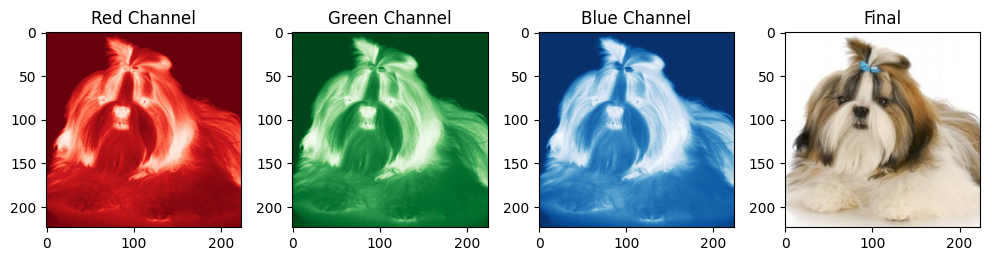

In [11]:
img = X_train[333]

rojo = img[:, :, 0]
verde = img[:, :, 1]
azul = img[:, :, 2]

# Create a figure and subplots to display the channels
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

# Display the red channel
axes[0].imshow(rojo, cmap='Reds')
axes[0].set_title('Red Channel')

# Display the green channel
axes[1].imshow(verde, cmap='Greens')
axes[1].set_title('Green Channel')

# Display the blue channel
axes[2].imshow(azul, cmap='Blues')
axes[2].set_title('Blue Channel')

# Display the blue channel
axes[3].imshow(img)
axes[3].set_title('Final')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [12]:
# Normalizamos los valores
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [13]:
#One-Hot Encoding
encoder =  ce.OneHotEncoder(return_df=False, handle_unknown="ignore")
encoder.fit_transform(y_train)
encoder.fit_transform(y_val)
encoder.fit_transform(y_test)

y_train_ = encoder.transform(y_train)
y_val_ = encoder.transform(y_val)
y_test_ = encoder.transform(y_test)

In [14]:
print(y_train[:10])
print(y_train_[:10])

['Lhasa' 'Labrador' 'Lhasa' 'Labrador' 'Shih-Tzu' 'Lhasa' 'Labrador'
 'Shih-Tzu' 'Shih-Tzu' 'Labrador']
[[1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]]


In [15]:
### ARQUITECTURA DE LA CONVOLUCIONAL ##
model = keras.Sequential([
    #Convolucional 1
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)),
    #Capa pooling 1
    layers.MaxPooling2D(pool_size=(2,2)),

    #Convolucional 2
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    #Capa pooling 2
    layers.MaxPooling2D(pool_size=(2,2)),

    #Convolucional 3
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    #Capa pooling 3
    layers.MaxPooling2D(pool_size=(2,2)),

    #Capa flatten
    layers.Flatten(),
    
    ### Capa densa 100 neuronas
    layers.Dense(100, activation='relu'),
    # Dropout
    layers.Dropout(0.2),

    ### Capa densa 100 neuronas
    layers.Dense(20, activation='relu'),

    ### Capa de salida
    layers.Dense(3, activation='softmax')
])

C:\Users\serch\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       2,163,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           2,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              63 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,184,775 (8.33 MB)

 Trainable params: 2,184,775 (8.33 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
## COMPILACIÓN DEL MODELO
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
)

In [18]:
# Entrenamiento del modelo
epochs = 20
bs = 10
history = model.fit(X_train, y_train_,
                    epochs=epochs,
                    batch_size=bs,
                    validation_data=(X_val, y_val_))

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.3562 - loss: 1.1330 - val_accuracy: 0.3333 - val_loss: 1.1189
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.4621 - loss: 1.0841 - val_accuracy: 0.5333 - val_loss: 0.9959
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.5705 - loss: 0.8849 - val_accuracy: 0.4667 - val_loss: 0.9412
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.7513 - loss: 0.6247 - val_accuracy: 0.4000 - val_loss: 1.0196
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.8511 - loss: 0.3797 - val_accuracy: 0.5667 - val_loss: 1.3078
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.9204 - loss: 0.2629 - val_accuracy: 0.5667 - val_loss: 1.4330
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.9473 - loss: 0.1614 - val_accuracy: 0.4667 - val_loss: 1.5862
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.9883 - loss: 0.0725 - val_accuracy: 

In [19]:
loss, accuracy = model.evaluate(X_train, y_train_)
print(f"Pérdida en entrenamiento: {loss:.4f}")
print(f"Precisión en entrenamiento: {accuracy:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9975 - loss: 0.0147
Pérdida en entrenamiento: 0.0148
Precisión en entrenamiento: 0.9963


In [20]:
loss, accuracy = model.evaluate(X_test, y_test_)
print(f"Pérdida en prueba: {loss:.4f}")
print(f"Precisión en prueba: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8333 - loss: 0.6417
Pérdida en prueba: 0.6417
Precisión en prueba: 0.8333


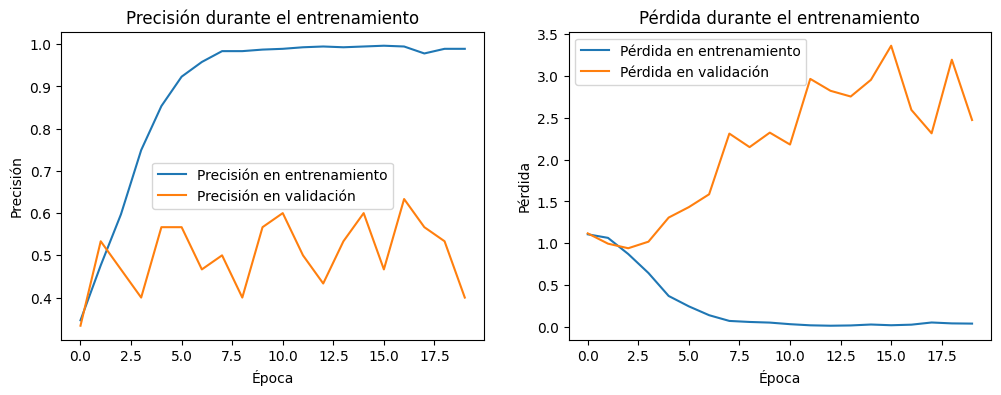

In [21]:
plt.figure(figsize=(12, 4)) ###grafica de precision durante entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2) ##graf perdida durante entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


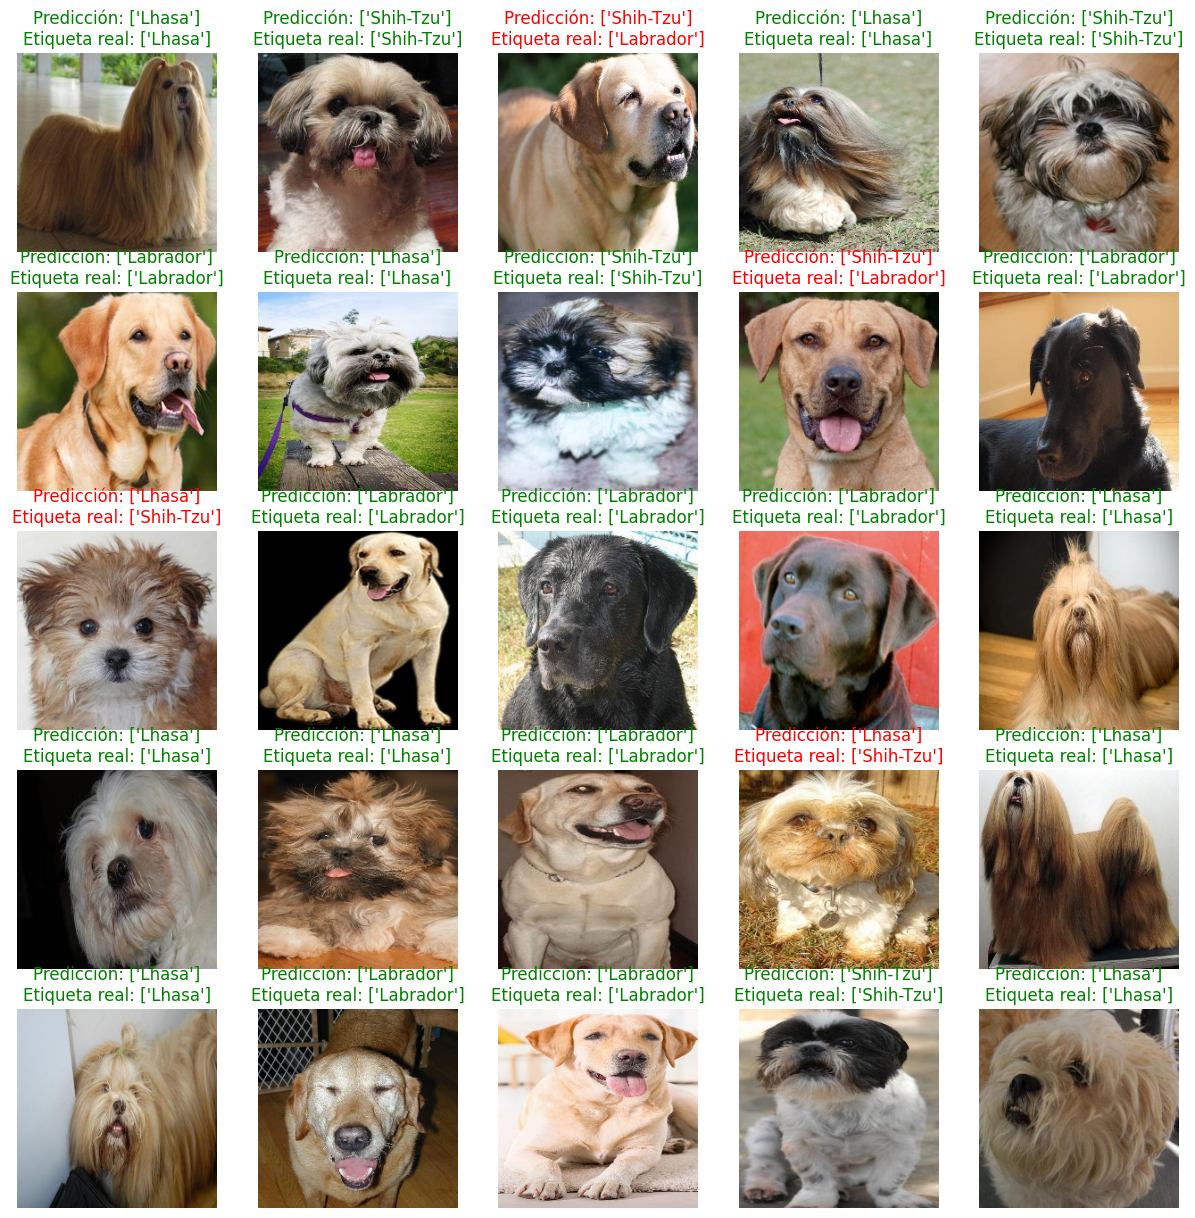

In [22]:
## ¿Funciona el código? Veámoslo de forma gráfica
predictions = (model.predict(X_test) >= 0.5).astype(int)
predicted_labels = encoder.inverse_transform(predictions)
true_labels = encoder.inverse_transform(y_test_)

plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[i], cmap='gray')
    color = 'green' if predicted_labels[i] == true_labels[i] else 'red'
    plt.title(f"Predicción: {predicted_labels[i]}\nEtiqueta real: {true_labels[i]}",color=color)
    plt.axis('off')
plt.show()

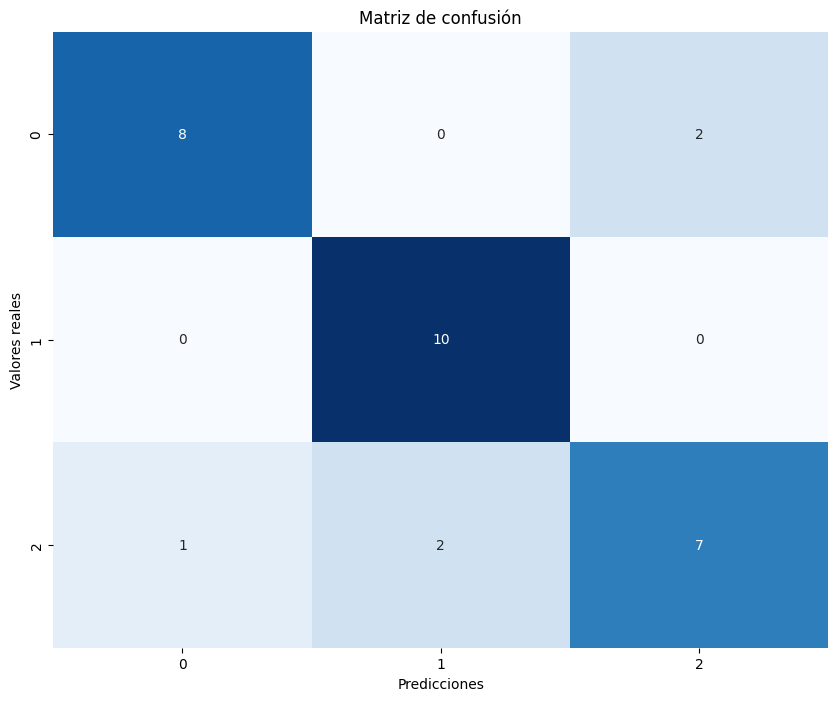

In [23]:
# Matríz de Confusión
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()

### Conclusiones

Se utilizó un dataset de de 606 imágenes de 3 razas de perros.
El objetivo de este trabajo es entrenar un modelo de red neuronal convolucional que sea capaz de clasificar correctamente las imágenes.

Las fotografias tomadas no son en las mismas condiciones: No se tiene el mismo fondo, ni la misma postura de los perros. 
También comparten la misma gama de colores.
Por lo que considero que la base de datos es pequeña, y no podemos esperar una precisión en datos de prueba que sea mayor a 90%.

El data set ya venía etiquetado con 90% para el entrenamiento, 5% para validación y 5% para prueba. Respeté esa partición aunque desconozco 
si se eligió aleatoriamente o si fue seleccionada por algún criterio en específico (pues la página no lo indica).

Se eligió una red neuronal convolucional con filtros para extraer las características más importantes de las imágenes.
Así como capas densas para eliminar linealidad. Y dropout para evitar el sobreajuste.

Las gráficas de la evolución de la precisión y el error en el entrenamiento y validación muestran que hay sobreajuste.
Sin embargo, se logra obtener una buena precisión.

Nota: No lo muestro aquí, pero con el optimizador Adagrad curiosamente se consigue menor sobreajuste pero también muy poca precisión (<45%).

Conclusión final: Se logra observar un 83% de precisión en los datos de prueba, por lo que el proyecto cumplió con el objetivo principal.